In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [23]:
def plot_sidebysides(t_df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
    sn.countplot(x = '{}'.format(col), data = t_df.query('num_lf == 0'), ax = ax1,\
                 order = t_df['{}'.format(col)].value_counts().index).set(title = 'No Liofish')
    sn.countplot(x = '{}'.format(col), data = t_df.query('num_lf > 0'), ax = ax2,\
                 order = t_df['{}'.format(col)].value_counts().index).set(title = 'Lionfish');

In [2]:
lf_df = pd.read_csv('../data/processed/lion_fish.csv')
df = pd.read_csv('../data/processed/combined_df.csv')
gdf = gpd.read_file("../data/processed/with_land_df.shp")

In [3]:
lf_df.head()

,Latitude,Longitude,Accuracy,Drainage Name,Year,Month,Day,lat_lon
0,18.433820,-64.444990,Accurate,Eastern Caribbean,2022,2.0,27.0,"(-64.44499, 18.43382)"
1,18.051071,-67.908004,Accurate,Greater Antilles,2010,1.0,10.0,"(-67.908004, 18.051071)"
2,18.112100,-67.934000,Accurate,Greater Antilles,2009,4.0,5.0,"(-67.934, 18.1121)"
3,17.938900,-67.023100,Approximate,Greater Antilles,2009,5.0,15.0,"(-67.0231, 17.9389)"
4,17.965800,-66.761600,Accurate,Greater Antilles,2010,6.0,6.0,"(-66.7616, 17.9658)"


In [4]:
df.head()

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,num_lf
0,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,0
1,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,0
2,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,0
3,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_4,0
4,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,STJ_5,0


In [5]:
gdf.head(3)

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366..."
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359..."
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356..."


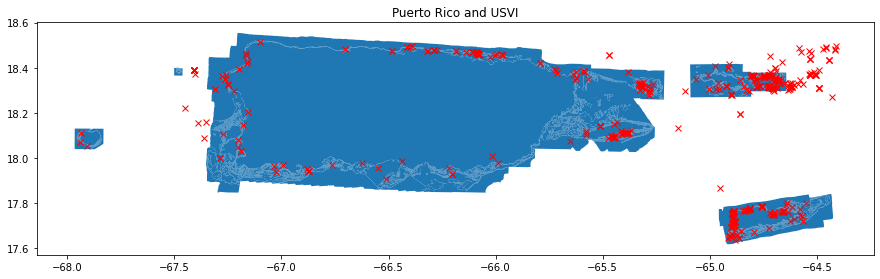

In [6]:
#some LF are on land and some outside the benthic mapping, they are not included in df
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(lf_df.Longitude, lf_df.Latitude, marker = 'x', color = 'r', linestyle = 'None')
plt.title('Puerto Rico and USVI')
gdf.plot(categorical=True, figsize=(10,10), markersize=45, ax=ax);

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DESCRIPTOR  7384 non-null   object
 1   ZONE        7384 non-null   object
 2   HABITAT     7384 non-null   object
 3   TYPE        7384 non-null   object
 4   polyid      7384 non-null   object
 5   num_lf      7384 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 346.2+ KB


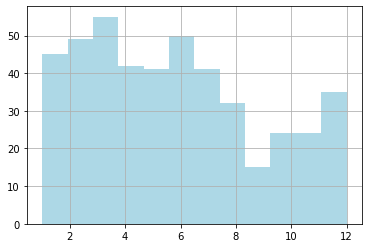

In [8]:
lf_df.Month.hist(color = 'lightblue', bins = 12);

ref. 3. The best time to visit the U.S. Virgin Islands is April to June, when you can expect mild weather and very little rainfall. In the USVI's peak season, from December to March, the temperature ranges from the mid-70s to high 80s with breezy evenings. July to October is the region's hurricane season with average temps in the upper 80s.

ref. 4. The best times to visit the U.S. Virgin Islands are December through April during the dry season. The warmer months of March and April are even better. But the best times also depend on what visitors plan to do when they get there. Some months are better than others for spending time on the beaches and in the water. The worst times to visit St. Thomas and the U.S. Virgin Islands are September through November. These months fall inside the heart of the Virgin Islands hurricane season, also known as the rainy season.

peak 12-3, 4-6, Hurricane Season 7-10 best 12-4, worst 9-11

???12-2, 3-5, 6-8, 9-11???

Null Hypothesis: The mean number of lionfish captured is not reduced during low tourism seasons. 

Alternative Hypotheis: The mean number of lionfish captured is correlated with seasonal tourist patterns.

In [9]:
low_season = len(lf_df.query('Month >= 9 and Month <=11'))/3
print('The mean number of reported lionfish during the months of September - November is {}' .format(low_season))

The mean number of reported lionfish during the months of September - November is 21.0


In [10]:
season_cnts = []
def seasonal_count(t_df, rands):
    lens = []
    for r in rands:
        lens.append(len(t_df.query('Month == {}' .format(r))))
    season_cnts.append(np.sum(lens)/3)
for i in range(10000):
    temp_df = lf_df[lf_df['Month'].notna()]
    rand_months = np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12], size = 3)
    seasonal_count(temp_df, rand_months)

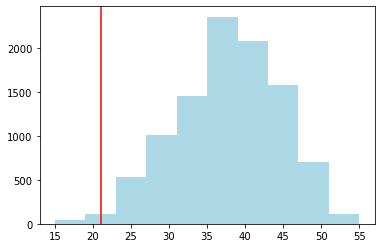

In [11]:
plt.axvline(x = low_season, color = 'r')
plt.hist(season_cnts, color = 'lightblue');

In [12]:
1 - np.sum([np.array(season_cnts) > low_season])/10000

0.013299999999999979

Conclusion: With a p-value of .01 the null hypothesis is rejected.

In [13]:
#total potetial combinations
d_unique = df.DESCRIPTOR.unique()
z_unique = df.ZONE.unique()
h_unique = df.HABITAT.unique()
t_unique = df.TYPE.unique()
print('Total Potential Combinations of Zone, Descriptor, Habitat, and Type: {}'.format(len(d_unique)* len(z_unique)\
                                                                                       * len(h_unique)* len(t_unique)))

Total Potential Combinations of Zone, Descriptor, Habitat, and Type: 19665


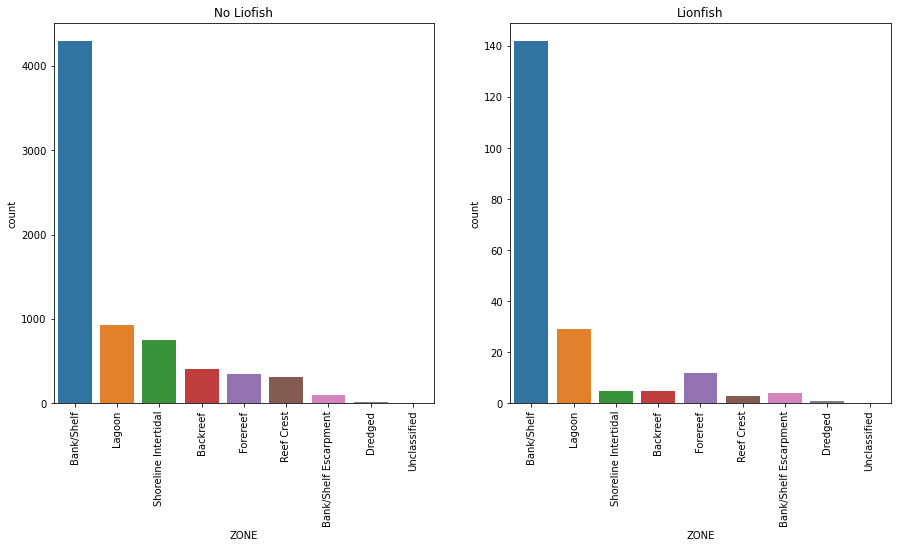

In [24]:
plot_sidebysides(df, 'ZONE')

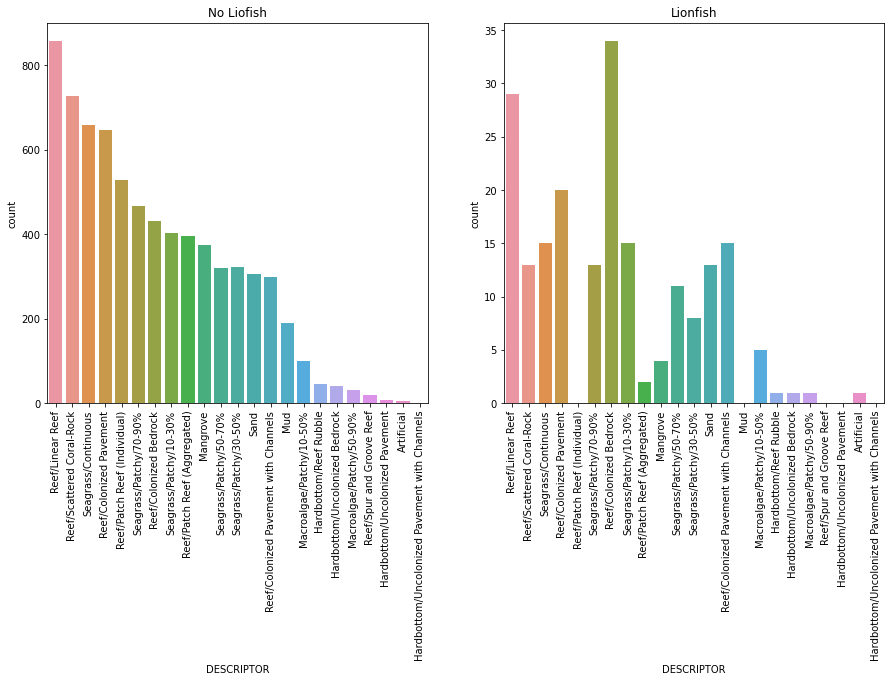

In [25]:
plot_sidebysides(df, 'DESCRIPTOR')

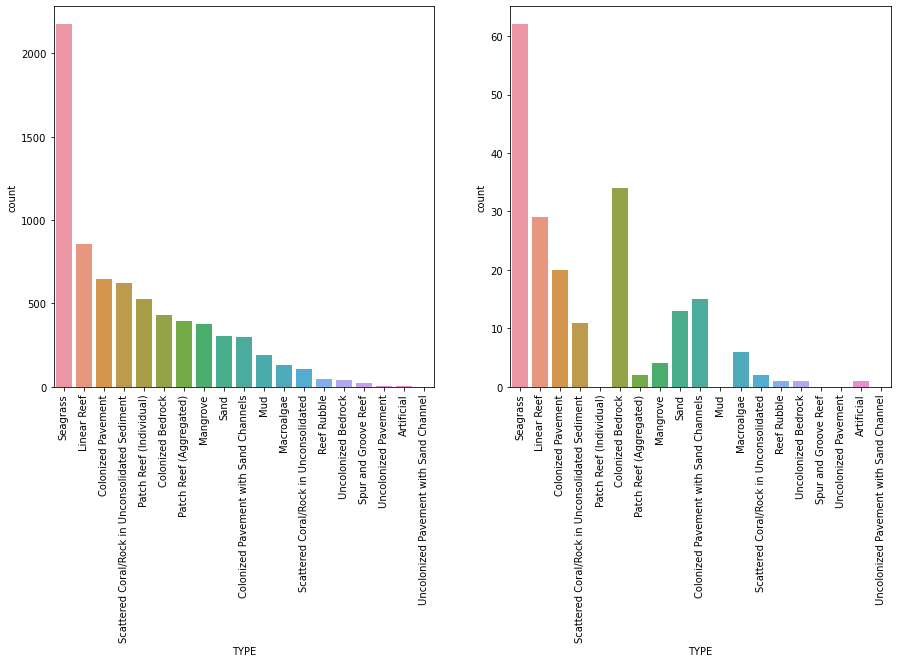

In [18]:
plot_sidebysides(df, 'TYPE')

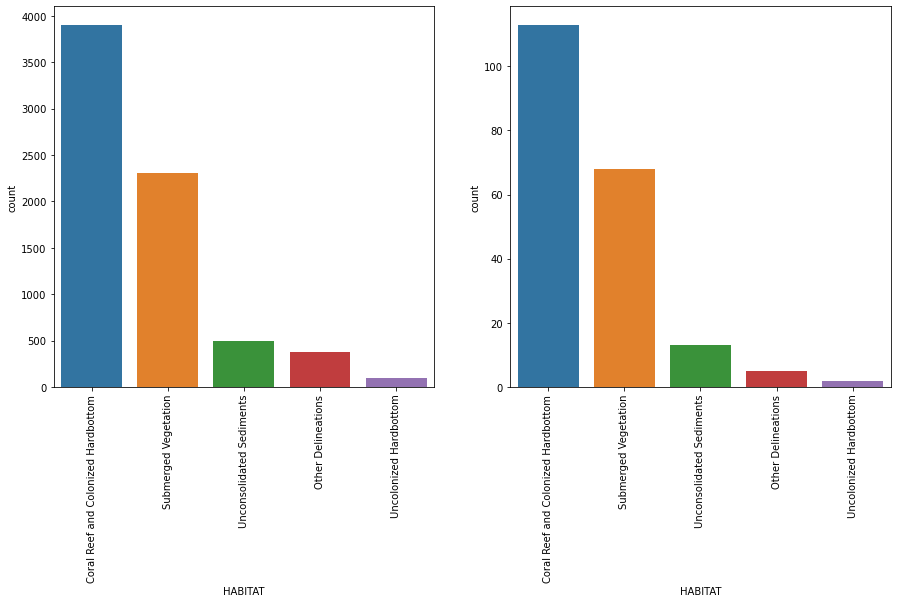

In [19]:
plot_sidebysides(df, 'HABITAT')

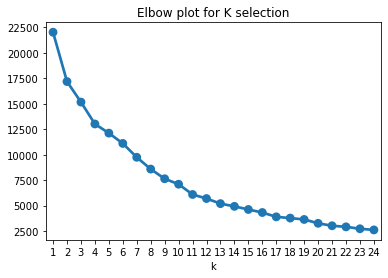

In [47]:
def elbow_plot(data):
    sse = {}
    for k in range(1, 25):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    sn.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()
k_train = pd.get_dummies(df[['DESCRIPTOR', 'ZONE', 'HABITAT', 'TYPE']], drop_first = False)
elbow_plot(k_train)

In [19]:
n_clusters = 21
kmeans = KMeans(n_clusters= n_clusters)
kmeans.fit(k_train)

KMeans(n_clusters=21)

In [20]:
t_clusters = kmeans.predict(k_train)
df['clusters'] = t_clusters

In [21]:
df.sample(5)

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,num_lf,clusters
4788,Seagrass/Patchy/10-30%,Bank/Shelf,Submerged Vegetation,Seagrass,PR_3730,0,12
2703,Mangrove,Shoreline Intertidal,Other Delineations,Mangrove,PR_1583,0,3
4584,Seagrass/Patchy/50-70%,Bank/Shelf,Submerged Vegetation,Seagrass,PR_3522,0,17
1364,Reef/Patch Reef (Individual),Bank/Shelf,Coral Reef and Colonized Hardbottom,Patch Reef (Individual),PR_156,0,8
2879,Seagrass/Patchy/30-50%,Bank/Shelf,Submerged Vegetation,Seagrass,PR_1768,0,1


In [22]:
id_df = df[['polyid', 'clusters']]
gdf = pd.merge(gdf, id_df, on = 'polyid')
gdf.head()

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry,clusters
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",11
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",11
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",18
3,4,5698.10,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_4,"POLYGON ((-64.81626 18.34365, -64.81617 18.344...",18
4,5,24547.68,31,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,None,None,None,STJ_5,"POLYGON ((-64.79880 18.35579, -64.79875 18.355...",16


In [23]:
cluster_prob1 = []
for c in range(n_clusters):
    cluster_id = c
    cluster_ = df.query('clusters == {}' .format(cluster_id))
    lf_w_cluster = df.query('num_lf >= 1')
    total_lf = lf_w_cluster['num_lf'].sum()
    lf_w_cluster_ = lf_w_cluster.query('clusters == {}' .format(cluster_id))
    num_lf_in_cluster = lf_w_cluster_['num_lf'].sum()
    p_lf = .5#201/7384
    p_C = len(cluster_)/len(df)
    p_C_lf = num_lf_in_cluster/total_lf
    cluster_prob1.append((p_C_lf * p_lf)/ p_C)
    print('Cluster id: {}, Probability: {}' .format(c, (p_C_lf * p_lf)/ p_C))

Cluster id: 0, Probability: 0.49879758977545996
Cluster id: 1, Probability: 0.32278683906315264
Cluster id: 2, Probability: 0.33704240924259793
Cluster id: 3, Probability: 0.12529163732618415
Cluster id: 4, Probability: 0.39352649624273867
Cluster id: 5, Probability: 0.5161470711589543
Cluster id: 6, Probability: 1.146378151608407
Cluster id: 7, Probability: 0.0
Cluster id: 8, Probability: 0.0
Cluster id: 9, Probability: 0.08970818113342027
Cluster id: 10, Probability: 0.35226654708177885
Cluster id: 11, Probability: 1.0047878720680585
Cluster id: 12, Probability: 0.7933143528075575
Cluster id: 13, Probability: 1.020787678948123
Cluster id: 14, Probability: 0.5076578101201557
Cluster id: 15, Probability: 0.7452885960232434
Cluster id: 16, Probability: 0.6227610563491645
Cluster id: 17, Probability: 0.6822633699227556
Cluster id: 18, Probability: 0.33284250383147523
Cluster id: 19, Probability: 0.7209341682179726
Cluster id: 20, Probability: 0.6881960948786057


In [24]:
cluster_prob = []
for c in range(n_clusters):
    #print(c)
    cluster_id = c
    cluster_ = df.query('clusters == {}' .format(cluster_id))
    lf_w_cluster = df.query('num_lf >= 1')
    lf_w_cluster_ = lf_w_cluster.query('clusters == {}' .format(cluster_id))
    p_lf = .5#201/7384
    p_C = len(cluster_)/len(df)
    p_C_lf = len(lf_w_cluster_)/len(lf_w_cluster)
    cluster_prob.append((p_C_lf * p_lf)/ p_C)
    print('Cluster id: {}, Probability: {}' .format(c, (p_C_lf * p_lf)/ p_C))

Cluster id: 0, Probability: 0.4630628370751285
Cluster id: 1, Probability: 0.44394342486960964
Cluster id: 2, Probability: 0.3186904593750491
Cluster id: 3, Probability: 0.19385920004200632
Cluster id: 4, Probability: 0.35518539897199086
Cluster id: 5, Probability: 0.5507693914236912
Cluster id: 6, Probability: 1.3401661221788057
Cluster id: 7, Probability: 0.0
Cluster id: 8, Probability: 0.0
Cluster id: 9, Probability: 0.0925348070729476
Cluster id: 10, Probability: 0.4087869259046016
Cluster id: 11, Probability: 0.7485456728894712
Cluster id: 12, Probability: 0.657571331884729
Cluster id: 13, Probability: 0.8774598345850365
Cluster id: 14, Probability: 0.48337261063105524
Cluster id: 15, Probability: 0.8236842692367758
Cluster id: 16, Probability: 0.722681673599217
Cluster id: 17, Probability: 0.6333848001372447
Cluster id: 18, Probability: 0.3433300785790673
Cluster id: 19, Probability: 0.5205551191411365
Cluster id: 20, Probability: 0.7986156175643521


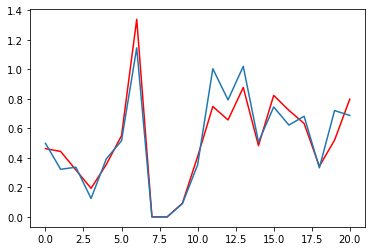

In [25]:
plt.plot(cluster_prob, color = 'r')
plt.plot(cluster_prob1);

In [26]:
cluster_prob_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(cluster_prob).reshape(-1,1))

In [27]:
cluster_prob_scaled

array([[0.34552645],
       [0.33126   ],
       [0.23779922],
       [0.14465311],
       [0.26503087],
       [0.41097099],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.06904727],
       [0.30502706],
       [0.55854693],
       [0.49066405],
       [0.6547396 ],
       [0.36068111],
       [0.61461356],
       [0.53924783],
       [0.47261663],
       [0.25618472],
       [0.38842582],
       [0.59590793]])

In [28]:
cluster_probs = []
def get_cluster_probs(x):
    cluster_probs.append(cluster_prob_scaled[x][0])
_ = gdf['clusters'].apply(get_cluster_probs)

In [29]:
gdf['rel_probs'] = cluster_probs 
gdf.head()

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry,clusters,rel_probs
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",11,0.558547
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",11,0.558547
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",18,0.256185
3,4,5698.10,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_4,"POLYGON ((-64.81626 18.34365, -64.81617 18.344...",18,0.256185
4,5,24547.68,31,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,None,None,None,STJ_5,"POLYGON ((-64.79880 18.35579, -64.79875 18.355...",16,0.539248


In [33]:
gdf.drop(['MODIFIER1', 'MODIFIER2', 'MODIFIER3', 'AREA', 'POLYGONID', 'ID'], axis = 1, inplace = True)

In [34]:
gdf.head(3)

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,rel_probs
0,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",11,0.558547
1,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",11,0.558547
2,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",18,0.256185


In [46]:
gdf.query('clusters == 7')

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,rel_probs
149,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STJ_161,"POLYGON ((-64.72449 18.31900, -64.72456 18.318...",7,0.0
643,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STJ_691,"POLYGON ((-64.86354 18.32049, -64.86356 18.320...",7,0.0
1017,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STJ_1083,"POLYGON ((-64.87147 18.30643, -64.87141 18.306...",7,0.0
1019,Mud,Dredged,Unconsolidated Sediments,Mud,STJ_1085,"POLYGON ((-64.95705 18.31112, -64.95698 18.311...",7,0.0
1039,Mud,Lagoon,Unconsolidated Sediments,Mud,STJ_1107,"POLYGON ((-64.85299 18.32452, -64.85299 18.324...",7,0.0
...,...,...,...,...,...,...,...,...
6418,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STC_210,"POLYGON ((-64.77011 17.69295, -64.76948 17.692...",7,0.0
6419,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STC_211,"POLYGON ((-64.77226 17.69346, -64.77226 17.693...",7,0.0
6429,Mud,Shoreline Intertidal,Unconsolidated Sediments,Mud,STC_221,"POLYGON ((-64.76348 17.70398, -64.76353 17.704...",7,0.0
7029,Mud,Lagoon,Unconsolidated Sediments,Mud,STC_826,"POLYGON ((-64.69017 17.75189, -64.69012 17.751...",7,0.0


In [28]:
#gdf.to_file('../data/processed/gdf_w_clusters.shp')